# Current hierarichy performance

## Problem

We are launching a recommendation tool that identifies vendor cohorts and
suggests performance improvements based on peer comparisons within those
cohorts.  This ad hoc approach creates two risks for our MVP rollout: Weak
statistical foundation: We haven't validated whether our cohorts actually group
similar-performing vendors together Stakeholder confidence: Without a principled
justification for cohort boundaries, leadership are questioning recommendation
validity For more details, see [RFC - Reco cohort updating](https://docs.google.com/document/d/1N57UfysXpHLFVXMAi5htYw2L8hBySiKq9frPIBlvaPk/edit?tab=t.0#heading=h.wcy3kyozl6o0)

## Current cohort rule

Our current cohort rule uses a six-level nested hierarchy (Country → City → Area
→ Price → Cuisine → Grade) that was designed primarily for explainability to
account managers rather than analytical rigor. One shortcoming of the cohort
rule is that when there are an insufficient number of chains in a cohort, the
fallback is often to a broad “All” category. For example, 8% of vendors in the
UAE are in a category with the following dimension values

- Entity: tb_ae 
- City: All 
- Area: All 
- Priciness: All 
- Cuisine: All 
- Vendor Grade: All

Why so many? Our belief is that this is due to the fallback logic. A fallback
occurs when a proposed cohort has too few vendors for reliable comparison. In
the current rule, we switch from a granular cohort to the broadest relevant
cohort with the most chain ids.

## This iteration

- We provide a baseline estimate of the current cohort performance
    - Focus on TB_AE for speedier development
    - We drop around 1% of vendors due to complexity of implementing full fallback
    - Inference also focused on one month, not necessarily predictive
- We compare the baseline with some simple adjustments
    - Removing the fallback hierarchy allows us to group vendors with similar revenue
- We investigate the predictive performance of cohort dimensions
    - Vendor grade is important
    - We should to include Key Account sub categories

## Recommendations 

One more cycle of development. Gun to my head recommendation for today: 
- ‘Hierarchical, no cuisine’ provides a boost to performance measure similarity
over the current, while the largest, worst case cohorts are reduced to areas
within a city rather than the whole market as with the current.

Update: after some discussion with Devin and Istiak, we've settled on basic
match and basic match no cuisine as the two best options. The reason is that we
want to focus on the variance within cohorts.


In [2]:
from pathlib import Path
from cohorts.cohort_statistics import (
    compare_outlier_methods, 
    process_dataframes_for_outliers, 
    process_dataframes_with_gmv,
    plot_figure_wrapper,
    pretty_print_output,
    get_top_cohort_items
    )

import os
import warnings
import numpy as np
import pandas as pd
import pandas_gbq
import bigframes.pandas as bpd

%load_ext google.cloud.bigquery
bpd.options.bigquery.project = "dhh-ncr-stg"

# where to save plots
CURRENT_DIR = Path(os.getcwd())
BASE_PLOT_PATH = CURRENT_DIR.parent / "figures" 

/Users/patrick.doupe/DH/ad_hoc/cohorts/.venv/lib/python3.13/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


In [3]:
# new cohort rules
BASIC = 'logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v1'
HIERARCHICAL = 'logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v2'
BASIC_NO_CUISINE = 'logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v1_cuisine'
HIERARCHICAL_NO_CUISINE = 'logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v2_cusine'
BASIC_MIN10 = 'logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v1_10'

In [6]:
base_sql_query = """
select * from (
select
*,
count(distinct concat(entity_id,vendor_code)) over (partition by cohort_id) as vendors,
from `{table_path}`
) where vendors>=5
"""

In [7]:
# For current cohort rules 
TARGET_ENTITY = 'TB_AE'
CREATED_MONTH = '2025-07-01'
CURRENT_COHORT_PATH = 'dhh-ncr-stg.patrick_doupe.current_cohort_vendor_base'

NEW_SUMMARY_TABLE_ID = 'patrick_doupe.cohort_basic_hierarchy_statistics'
PROJECT_ID = 'dhh-ncr-stg'

current_query = """
    SELECT 
        global_entity_id AS entity_id,
        vendor_id AS vendor_code,
        cohort_id,
        COALESCE(gmv, 0) AS gmv 
    FROM `{path}` WHERE global_entity_id = '{target_entity}' AND DATE(created_month) = '{created_month}' 
"""

In [8]:
df_basic = pandas_gbq.read_gbq(base_sql_query.format(table_path=BASIC))
df_h = pandas_gbq.read_gbq(base_sql_query.format(table_path=HIERARCHICAL))
df_basic_no_cuisine = pandas_gbq.read_gbq(base_sql_query.format(table_path=BASIC_NO_CUISINE))
df_h_no_cuisine = pandas_gbq.read_gbq(base_sql_query.format(table_path=HIERARCHICAL_NO_CUISINE))
df_basic_min10 = pandas_gbq.read_gbq(base_sql_query.format(table_path=BASIC_MIN10))

df_current = pandas_gbq.read_gbq(current_query.format(path=CURRENT_COHORT_PATH, target_entity=TARGET_ENTITY, created_month=CREATED_MONTH))

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|


In [7]:
df_current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27709 entries, 0 to 27708
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    27709 non-null  object
 1   vendor_code  27709 non-null  object
 2   cohort_id    27709 non-null  Int64 
 3   gmv          27709 non-null  object
dtypes: Int64(1), object(3)
memory usage: 893.1+ KB


In [8]:
df_current['gmv'] = pd.to_numeric(df_current['gmv'], errors='coerce')

df_list_mapping = {
    'basic': df_basic,
    'basic_min10': df_basic_min10,
    'basic_no_c': df_basic_no_cuisine,
    'hierarchy': df_h,
    'hierarchy_no_cuisine': df_h_no_cuisine
}

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=PendingDeprecationWarning)
    processed_dfs = process_dataframes_with_gmv(
        original_df=df_current,
        dataframes_to_process=df_list_mapping,
    )

Starting GMV processing for 5 dataframes...
  853 vendors from 'basic' were not found in GMV source.
  854 vendors from 'basic_min10' were not found in GMV source.
  856 vendors from 'basic_no_c' were not found in GMV source.
  837 vendors from 'hierarchy' were not found in GMV source.
  855 vendors from 'hierarchy_no_cuisine' were not found in GMV source.

GMV processing complete.


In [10]:
test = processed_dfs['basic'].copy()
test.head()

,created_date,region,entity_id,vendor_code,cohort_id,is_valid_cohort,cohort_features,granularity_rank,cohort_rank,cohort_success,updated_at,real_cohort_vendor_numbers,segment,real_cohort_vendor_numbers_u,vendors,gmv,_merge
0,2025-07-02,MENA,TB_AE,711110,20785,True,"{""area"":""Al Hosn"",""budget"":""All"",""city"":""abu d...",2,2,"{'successful_vendors_in_cohort': 51, 'successf...",2025-07-02 22:37:52.544840+00:00,36,best_match,15,15,90.31,both
1,2025-07-02,MENA,TB_AE,49427,20785,True,"{""area"":""Al Hosn"",""budget"":""All"",""city"":""abu d...",2,2,"{'successful_vendors_in_cohort': 51, 'successf...",2025-07-02 22:37:52.544840+00:00,36,best_match,15,15,277.42,both
2,2025-07-02,MENA,TB_AE,679575,20785,True,"{""area"":""Al Hosn"",""budget"":""All"",""city"":""abu d...",2,2,"{'successful_vendors_in_cohort': 51, 'successf...",2025-07-02 22:37:52.544840+00:00,36,best_match,15,15,164.74,both
3,2025-07-02,MENA,TB_AE,34786,20785,True,"{""area"":""Al Hosn"",""budget"":""All"",""city"":""abu d...",2,2,"{'successful_vendors_in_cohort': 51, 'successf...",2025-07-02 22:37:52.544840+00:00,36,best_match,15,15,78.33,both
4,2025-07-02,MENA,TB_AE,761272,20785,True,"{""area"":""Al Hosn"",""budget"":""All"",""city"":""abu d...",2,2,"{'successful_vendors_in_cohort': 51, 'successf...",2025-07-02 22:37:52.544840+00:00,36,best_match,15,15,140.06,both


In [11]:
test.loc[test._merge == 'left_only'].head()

,created_date,region,entity_id,vendor_code,cohort_id,is_valid_cohort,cohort_features,granularity_rank,cohort_rank,cohort_success,updated_at,real_cohort_vendor_numbers,segment,real_cohort_vendor_numbers_u,vendors,gmv,_merge
169,2025-07-02,MENA,TB_AE,43227,75631,True,"{""area"":""All"",""budget"":""All"",""city"":""fujairah""...",3,2,"{'successful_vendors_in_cohort': 214, 'success...",2025-07-02 22:37:52.544840+00:00,16,second_match,38,38,0.0,left_only
195,2025-07-02,MENA,TB_AE,765633,75631,True,"{""area"":""All"",""budget"":""All"",""city"":""fujairah""...",3,5,"{'successful_vendors_in_cohort': 214, 'success...",2025-07-02 22:37:52.544840+00:00,22,best_match,38,38,0.0,left_only
252,2025-07-02,MENA,TB_AE,46156,126174,True,"{""area"":""Jumeirah 1"",""budget"":""All"",""city"":""du...",1,1,"{'successful_vendors_in_cohort': 12, 'successf...",2025-07-02 22:37:52.544840+00:00,12,best_match,12,12,0.0,left_only
323,2025-07-02,MENA,TB_AE,765049,128348,True,"{""area"":""Jumeirah Lakes Towers - JLT"",""budget""...",2,2,"{'successful_vendors_in_cohort': 349, 'success...",2025-07-02 22:37:52.544840+00:00,81,best_match,71,71,0.0,left_only
333,2025-07-02,MENA,TB_AE,737611,147106,True,"{""area"":""Muwaileh Commercial"",""budget"":""All"",""...",2,2,"{'successful_vendors_in_cohort': 44, 'successf...",2025-07-02 22:37:52.544840+00:00,26,best_match,26,26,0.0,left_only


In [12]:
random_vendor_code = test.loc[test._merge == 'left_only'].sample(n=1).vendor_code.values[0]
test.loc[test.vendor_code == random_vendor_code]

,created_date,region,entity_id,vendor_code,cohort_id,is_valid_cohort,cohort_features,granularity_rank,cohort_rank,cohort_success,updated_at,real_cohort_vendor_numbers,segment,real_cohort_vendor_numbers_u,vendors,gmv,_merge
8765,2025-07-02,MENA,TB_AE,712612,147111,True,"{""area"":""Muwaileh Commercial"",""budget"":""All"",""...",2,2,"{'successful_vendors_in_cohort': 122, 'success...",2025-07-02 22:37:52.544840+00:00,59,best_match,59,59,0.0,left_only


In the short run, I am happy with imputing zero GMV for these vendors. There doesn't seem to be an order for the last 365 days (please refresh, retry)

In [13]:
%%bigquery
SELECT *
FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders`
  WHERE partition_date_local >= DATE_SUB('2025-07-01', INTERVAL 365 DAY)
  AND global_entity_id = 'TB_AE_46156' 

Query is running:   0%|          |

Downloading: |          |

,order_uid,vendor_uid,brand_name,global_entity_id,order_id,vendor_id,customer_account_id,customer_id,analytical_customer_id,correlation_id,...,fx_rate_usd,items,total_items_quantity,platform_reference_id,eligibilities,addons,perseus,frontend_client,order_updates,metadata


In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    outlier_summary_results = process_dataframes_for_outliers(
        processed_dfs,
        'gmv',
        'cohort_id'
    )

pandas_gbq.to_gbq(outlier_summary_results, NEW_SUMMARY_TABLE_ID, project_id=PROJECT_ID, if_exists='replace')

outlier_summary_results

Processing DataFrame: current...
Processing DataFrame: basic...
Processing DataFrame: basic_min10...
Processing DataFrame: basic_no_c...
Processing DataFrame: hierarchy...
Processing DataFrame: hierarchy_no_cuisine...


100%|██████████| 1/1 [00:00<00:00, 7410.43it/s]


,df_name,share_cohorts_with_outlier_IQR,share_cohorts_with_outlier_5x,iqr_total_outliers,mean_5x_total_outliers,overlap_total_vendors,KW_H,epsilon_squared,p_value,f_stat_scipy,f_stat_manual,ms_b_manual,ms_w_manual
0,current,0.285768,0.148659,1053,544,522,13624.550059,0.491684,0.0,11.275609,11.275609,2.924127e+06,259332.064035
1,basic,0.248656,0.142473,574,361,326,18501.525282,0.655223,0.0,54.620459,54.620459,7.074143e+06,129514.533904
2,basic_min10,0.311024,0.257218,470,410,349,18212.714143,0.644743,0.0,98.555892,98.555892,1.299535e+07,131857.641004
3,basic_no_c,0.264865,0.177297,497,403,344,17808.250012,0.628778,0.0,84.715134,84.715134,1.153350e+07,136144.475845
4,hierarchy,0.297932,0.172235,954,488,448,12457.759400,0.448314,0.0,5.958779,5.958779,1.962898e+06,329412.779188
5,hierarchy_no_cuisine,0.329644,0.237945,766,524,468,14888.467961,0.525704,0.0,22.797761,22.797761,5.867116e+06,257354.915785


In [15]:

from typing import Optional
from pandas import DataFrame

Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/f_statistic.png


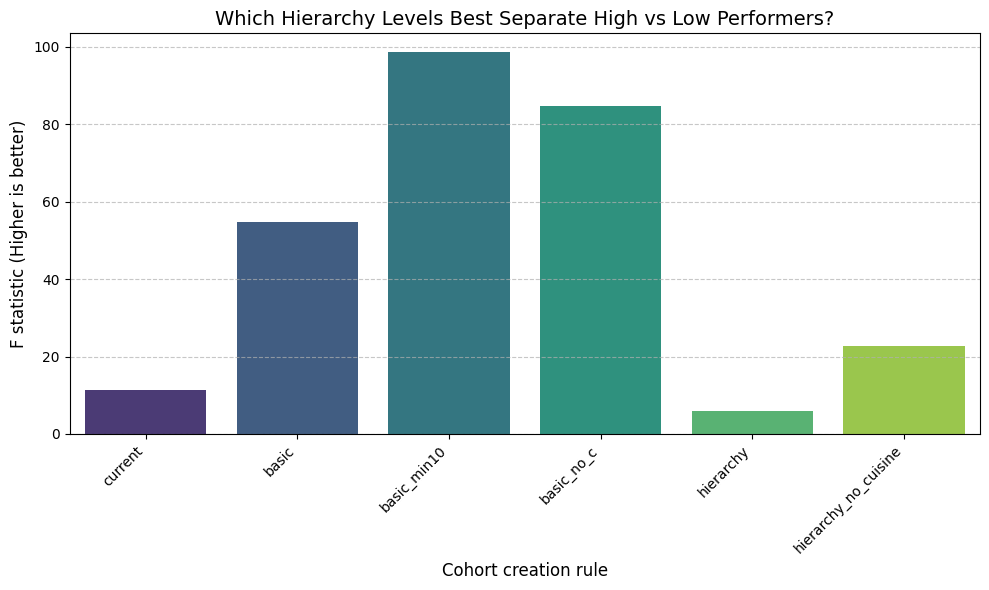

In [17]:
STATISTIC='f_stat_manual'
Y_LABEL='F statistic (Higher is better)'
TITLE='Which Hierarchy Levels Best Separate High vs Low Performers?'
OUTPUT_PATH=BASE_PLOT_PATH / 'f_statistic.png'

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plot_figure_wrapper(outlier_summary_results, STATISTIC, Y_LABEL, TITLE, OUTPUT_PATH)

Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/share_cohorts_with_outlier_5x.png


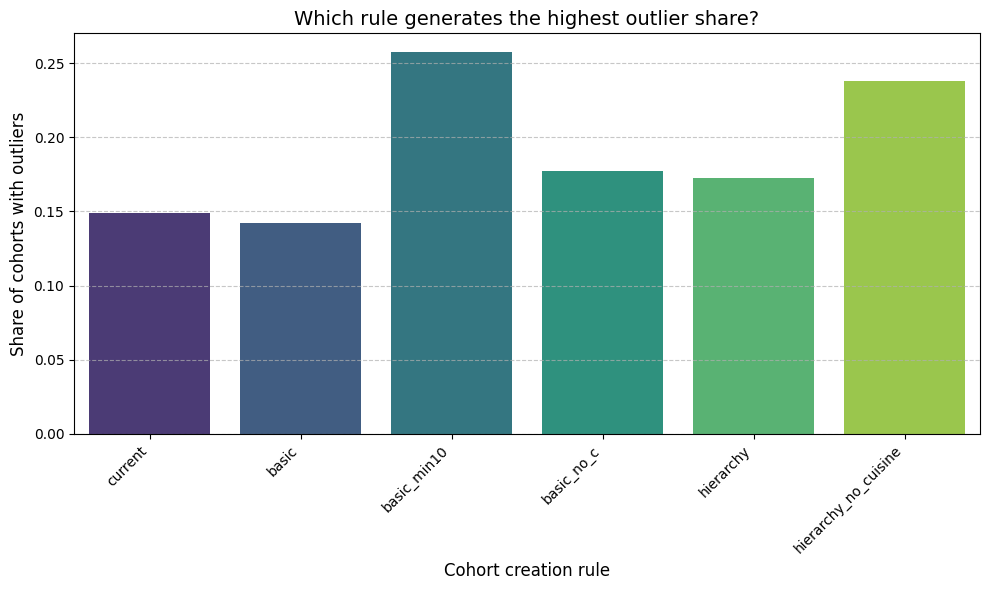

In [18]:
STATISTIC='share_cohorts_with_outlier_5x'
Y_LABEL='Share of cohorts with outliers'
TITLE='Which rule generates the highest outlier share?'
OUTPUT_PATH=BASE_PLOT_PATH/ f"{STATISTIC}.png"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plot_figure_wrapper(outlier_summary_results, STATISTIC, Y_LABEL, TITLE, OUTPUT_PATH)

Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/ms_b_manual.png


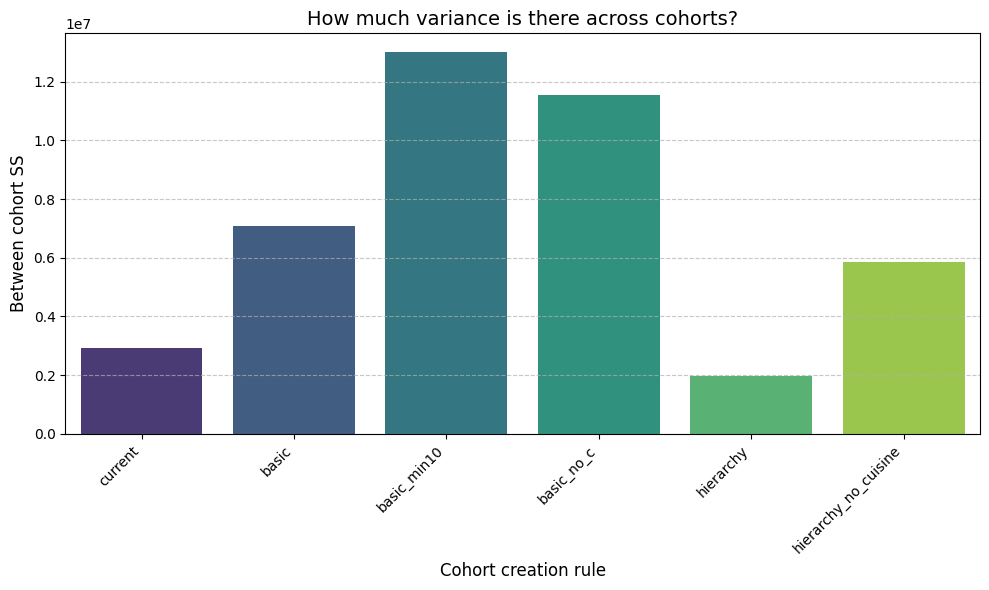

In [19]:
STATISTIC='ms_b_manual'
Y_LABEL='Between cohort SS'
TITLE='How much variance is there across cohorts?'
OUTPUT_PATH=BASE_PLOT_PATH/ f"{STATISTIC}.png"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plot_figure_wrapper(outlier_summary_results, STATISTIC, Y_LABEL, TITLE, OUTPUT_PATH)

Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/ms_w_manual.png


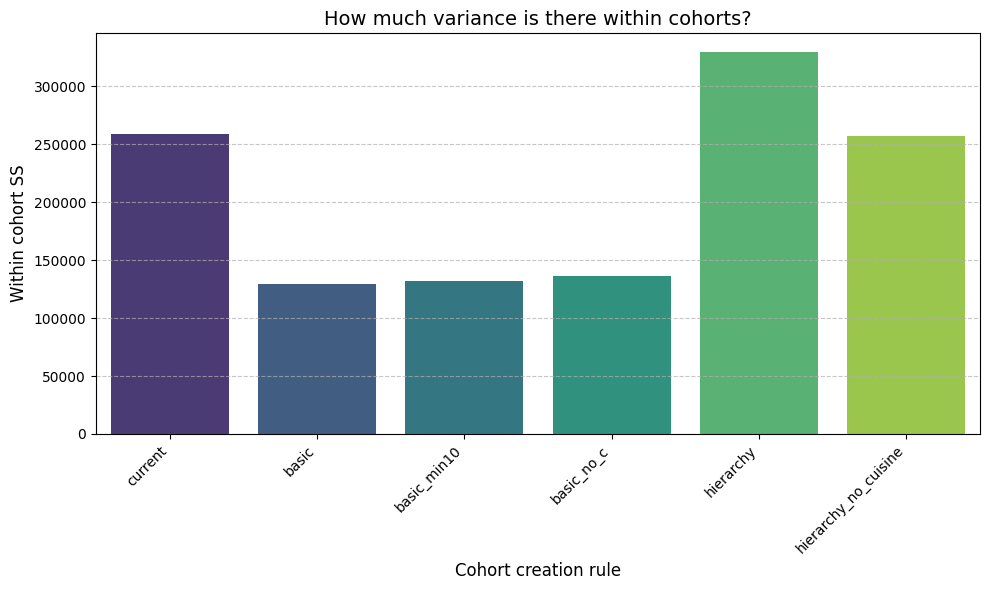

In [20]:
STATISTIC='ms_w_manual'
Y_LABEL='Within cohort SS'
TITLE='How much variance is there within cohorts?'
OUTPUT_PATH=BASE_PLOT_PATH/ f"{STATISTIC}.png"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plot_figure_wrapper(outlier_summary_results, STATISTIC, Y_LABEL, TITLE, OUTPUT_PATH)

In [21]:
current_stats = compare_outlier_methods(df_current, 'gmv', 'cohort_id')
corrcoef = np.corrcoef(current_stats.cohort_size, current_stats.mean_5x_outliers)
print(f"The correlation between cohort size and the number of outliers in the current cohorting rule is {corrcoef[0][1]:.2f}")

The correlation between cohort size and the number of outliers in the current cohorting rule is 0.97


In [ ]:
df_b

In [9]:
pretty_print_output(get_top_cohort_items(df_basic_no_cuisine))

Cohort ID: 74650
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "NA"
}
Unique Vendors: 1088
------------------------------
Cohort ID: 94453
Features:
{
    "area": "Business Bay",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 568
------------------------------
Cohort ID: 107896
Features:
{
    "area": "Dubai Silicon Oasis",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 405
------------------------------
Cohort ID: 72367
Features:
{
    "area": "All",
    "budget": "All",
    "city": "abu dhabi",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "NA"
}
Unique Vendors: 392
------------------------------
Cohort ID: 128348
Features:
{
    "area": "Jumeirah Lakes Towers - JLT",
    "budget": "All",
    "city": "dubai",
    

In [10]:
pretty_print_output(get_top_cohort_items(df_basic_min10))

Cohort ID: 74650
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "NA"
}
Unique Vendors: 373
------------------------------
Cohort ID: 74649
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 324
------------------------------
Cohort ID: 94454
Features:
{
    "area": "Business Bay",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "NA"
}
Unique Vendors: 290
------------------------------
Cohort ID: 74952
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "Indian",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 268
------------------------------
Cohort ID: 74648
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
   

In [24]:
pretty_print_output(get_top_cohort_items(df_h))

Cohort ID: 26274
Features:
{
    "area": "Al Karama",
    "budget": "All",
    "city": "dubai",
    "cuisine": "Indian",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 84
------------------------------
Cohort ID: 106811
Features:
{
    "area": "Dubai Motor City",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 67
------------------------------
Cohort ID: 94453
Features:
{
    "area": "Business Bay",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 67
------------------------------
Cohort ID: 74953
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "Indian",
    "entity": "tb_ae",
    "vendor_grade": "NA"
}
Unique Vendors: 65
------------------------------
Cohort ID: 8160
Features:
{
    "area": "Al Barsha 1",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
 